In [ ]:
#important libraries to load
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats # for stats.probplot, check QQ plot for normally distributed data
import seaborn as sns
from scipy.stats import f_oneway # one-way ANOVA
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [ ]:
file_path = "C:\\Users\\miyoh\\OneDrive - University of Toronto\\University\\University of Toronto\\Diamandis Lab\\Analyses\\People Analyses\\Miyo\\2025\\KLK6 assay\\KLK6 for Morato samples.xlsx"
df= pd.read_excel(file_path, "Sheet2")

In [ ]:
df #check that it was read fine

In [ ]:
#the columns need to be renamed

df.columns = df.iloc[0] #the new column names are taken from row 1
df = df.drop(df.index[0]) #drop the first row, since we have now saved is as column names

In [ ]:
df #check that it worked, new column names should be Value, ID, Group

In [ ]:
#make Value column a numeric value

#In order to do QQ-plots later, I have to turn the Value column into a float (rather than have it as object)
#this way, the other two columns remain intact, without being removed

df = df[["ID", "Group", "Value"]].apply(pd.to_numeric, errors = "ignore")

To see if the data are normally distributed, it is possible to run two statistical tests:
- Shapiro-Wilk Test, which is suitable for smaller sample sizes (typically <50), where the null hypothesis is that the data are normally distributed.
- D'Agostino's K-squared test (normaltest), which is based on skewness and kurtosis and is generally suitable for larger sample sizes. Similar to Shapiro-Wilk, a low p-value suggests non-normalilty.

In [ ]:
#perform D"Agostino K^2 test

groups = df['Group'].unique() #group by Group

for group_name in groups:
    group_data = df[df["Group"] == group_name]["Value"]
    statistic, p_value = stats.normaltest(group_data) #if we wanted to do Shapiro-Wilk, we would run a shapiro()
    print(f"Normality test for Group {group_name}:")
    print(f" D'Agostino K^2 Statistic: {statistic:.4f}")
    print(f" P-value: {p_value:.4f}")

    alpha = 0.05 #significance level
    if p_value > alpha:
        print(f"Result: Data for Group {group_name} appears to be normally distributed (fail to reject H0)")
    else:
        print(f"Result: Data for group {group_name} does not appear to be normally distributed (reject H0)")
    print("-" * 30)

In [ ]:
#alternatively, check normal distribution using QQ plot

for group_name in groups:
    group_data = df[df["Group"] == group_name]["Value"]
    stats.probplot(group_data,dist = "norm", plot=plt)
    plt.title("Q-Q Plot of Values")
    plt.show()

In [ ]:
#Since our data is not normally distributed, we log2 transform our values
#in a new column, which will be used from now on

df["log2_Value"] = np.log2(df["Value"])

In [80]:
#Check for normality again using the log2 values

for group_name in groups:
    group_data = df[df["Group"] == group_name]["log2_Value"]
    statistic, p_value = stats.normaltest(group_data)
    print(f"Normality test for Group {group_name}:")
    print(f" Shapiro-Wilk Statistic: {statistic:.4f}")
    print(f" P-value: {p_value:.4f}")

    alpha = 0.05 #significance level
    if p_value > alpha:
        print(f"Result: Data for Group {group_name} appears to be normally distributed (fail to reject H0)")
    else:
        print(f"Result: Data for group {group_name} does not appear to be normally distributed (reject H0)")
    print("-" * 30)

Normality test for Group MCI_nonProgressor:
 Shapiro-Wilk Statistic: 0.0006
 P-value: 0.9997
Result: Data for Group MCI_nonProgressor appears to be normally distributed (fail to reject H0)
------------------------------
Normality test for Group MCI_conver_toDem:
 Shapiro-Wilk Statistic: 4.0030
 P-value: 0.1351
Result: Data for Group MCI_conver_toDem appears to be normally distributed (fail to reject H0)
------------------------------
Normality test for Group SCD:
 Shapiro-Wilk Statistic: 0.3784
 P-value: 0.8276
Result: Data for Group SCD appears to be normally distributed (fail to reject H0)
------------------------------
Normality test for Group AD:
 Shapiro-Wilk Statistic: 5.9537
 P-value: 0.0510
Result: Data for Group AD appears to be normally distributed (fail to reject H0)
------------------------------


We have to perform the statistics, in this case a one-way ANOVA test (parametric)

In [ ]:
#Create 4 groups for stat analysis based on Group column
group_nonprog = df[df["Group"] == "MCI_nonProgressor"]['log2_Value']
group_prog = df[df["Group"] == "MCI_conver_toDem"]['log2_Value']
group_SCD= df[df["Group"] == "SCD"]['log2_Value']
group_AD = df[df["Group"] == "AD"]['log2_Value']

In [ ]:
#One-way ANOVA

f_statistic, p_value = f_oneway(group_SCD, group_prog, group_AD, group_nonprog)
print(f"F-statistic: {f_statistic}")
print(f"P-value: {p_value}")

#interpretation:

alpha = 0.05 #significance level
if p_value <alpha:
    print("Reject the null hypothesis: There is a significant difference between the groups")
else:
    print("Fail to reject the null hypothesis: there is no significant differences between the groups")

In order to see which groups are significantly different from each other, a post-hoc test is used. Tukey's is a common choice.

In [ ]:
tukey_result = pairwise_tukeyhsd(endog=df['log2_Value'], groups = df['Group'], alpha = 0.05)
print(tukey_result)
p_values = tukey_result.pvalues

In [ ]:
p_values #check to see what the different p_values are to use later

In [81]:
# Function to add significance bars with custom symbols
def add_sig_bars(ax, group1, group2, p_value, x1, x2, y):
    """Add significance bars with custom symbols and sizes based on p-value."""
    y_offset = 0.2  # Offset for the bar
    ax.plot([x1, x1, x2, x2], [y, y + y_offset, y + y_offset, y], color='black')
    
    # Annotate with different symbols based on p-value
    if p_value < 0.001:
        ax.text((x1 + x2) / 2, y + y_offset + 0.1, '***', fontsize=12, ha='center', color='red')
    elif p_value < 0.01:
        ax.text((x1 + x2) / 2, y + y_offset + 0.1, '**', fontsize=12, ha='center', color='orange')
    elif p_value < 0.05:
        ax.text((x1 + x2) / 2, y + y_offset + 0.1, '*', fontsize=12, ha='center', color='blue')

C:\Users\miyoh\AppData\Local\Temp\ipykernel_39924\1072527576.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(y = df["log2_Value"], x= df["Group"], palette= "RdBu")


(7.105036179299593, 11.0)

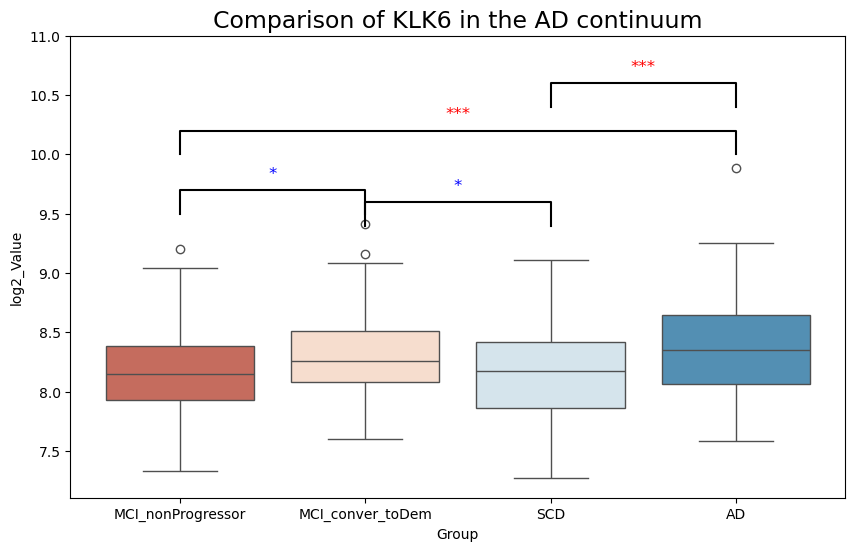

In [85]:
plt.figure(figsize=(10,6))
ax = sns.boxplot(y = df["log2_Value"], x= df["Group"], palette= "RdBu")

#manually check the sig p values
add_sig_bars(ax, "MCI_nonProgessor", "MCI_conver_toDem",p_values[3],0 ,1, 9.5)
add_sig_bars(ax, "AD", "MCI_nonProgessor",p_values[1],0 ,3, 10)
add_sig_bars(ax, "AD", "SCD",p_values[2],2 ,3, 10.4)
add_sig_bars(ax, "SCD", "MCI_conver_toDem",p_values[4],1 ,2, 9.4)


plt.title("Comparison of KLK6 in the AD continuum", fontsize = 17)
plt.ylim(top=11.0)